In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft
import tqdm

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [2]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import multiprocessing as mp
import tqdm
from functools import partial

from specsens import util
from specsens import util_sim
from specsens import WirelessMicrophone
from specsens import WhiteGaussianNoise
from specsens import Stft
from specsens import WidebandEnergyDetector
from specsens import noise_est as noise_esti


def generation(f_sample, length_sec, itrs, noise_power, signal_power,
               noise_uncert, window, fft_len, sigs, num_bands,
               band_noise_est, cov_size, seeds):

    # create new signal objects
    wm = WirelessMicrophone(f_sample=f_sample, t_sec=length_sec, seed=seeds[0])
    wgn = WhiteGaussianNoise(f_sample=f_sample,
                             t_sec=length_sec,
                             seed=seeds[1])

    # local rng
    rng = np.random.default_rng(seeds[2])

    # calculate noise power with uncertainty
    gen_noise_power = rng.normal(loc=noise_power, scale=noise_uncert)

    # list of noise estimation errors
    errs_time = np.array([])
    errs_band = np.array([])
    errs_eig_avg = np.array([])
    errs_eig_hist = np.array([])
    errs_eig_kde = np.array([])
    errs_eig_mle = np.array([])

    # 'inner' interations loop
    for _ in range(itrs):

        sig = wm.soft(f_center=0., power=signal_power, dB=True)
        for i in range(-int(sigs*100000), 0, 50000):
            sig += wm.soft(f_center=i, power=signal_power, dB=True)
        for i in range(50000, int(sigs*100000+50000), 50000):
            sig += wm.soft(f_center=i, power=signal_power, dB=True)
        
        # generate noise
        noise = wgn.signal(power=gen_noise_power, dB=True)

        # create acutal signal
        both = sig + noise

        # time noise estimation
        est_time = util.dB_power(np.mean(np.abs(noise)**2.))

        # create a Short Time Fourier Transform object
        sft = Stft(n=fft_len, window=window)
        # use the stft to transform the signal into the frequency domain
        f, psd = sft.stft(both, f_sample, normalized=False, dB=False)
#         f, psd = sft.stft(noise, f_sample, normalized=False, dB=False)
        # create a Wideband Energy Detector object
        fed = WidebandEnergyDetector(num_bands=num_bands,
                                     f_sample=f_sample,
                                     fft_len=fft_len,
                                     freqs=f)
        # compute energy for all bands
        bands = fed.detect(psd)
        # in band noise estimation
        est_band = util.dB_power(bands[band_noise_est] / (fft_len / num_bands))

        # eigenvalue noise estimation
        est_eig_avg, est_eig_hist, est_eig_kde, est_eig_mle = noise_esti.estimate(
            both, int(f_sample * length_sec), l=cov_size)

        # calculate errors
        err_time = util.dB_rel_err(gen_noise_power, est_time)
        err_band = util.dB_rel_err(gen_noise_power, est_band)
        err_eig_avg = util.dB_rel_err(gen_noise_power, est_eig_avg)
        err_eig_hist = util.dB_rel_err(gen_noise_power, est_eig_hist)
        err_eig_kde = util.dB_rel_err(gen_noise_power, est_eig_kde)
        err_eig_mle = util.dB_rel_err(gen_noise_power, est_eig_mle)

        # append to errors list
        errs_time = np.append(errs_time, err_time)
        errs_band = np.append(errs_band, err_band)
        errs_eig_avg = np.append(errs_eig_avg, err_eig_avg)
        errs_eig_hist = np.append(errs_eig_hist, err_eig_hist)
        errs_eig_kde = np.append(errs_eig_kde, err_eig_kde)
        errs_eig_mle = np.append(errs_eig_mle, err_eig_mle)

    # calculate average error and return
    return np.mean(errs_time), np.mean(errs_band), np.mean(
        errs_eig_avg), np.mean(errs_eig_hist), np.mean(errs_eig_kde), np.mean(
            errs_eig_mle)


def estimation_comparison_sim(
        gens=50,  # generations, number of environments
        itrs=300,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=0.,  # in dB
        sigs=0,  # signals
        noise_power=0.,  # in dB
        length_sec=None,  # length of each section in seconds
        num_samples=None,  # number of samples
        noise_uncert=0.0,  # standard deviation of the noise normal distribution
        seed=None,  # random seed used for rng
        num_procs=None,  # number of processes to run in parallel
        window='box',  # window used with fft
        fft_len=1024,  # samples used for fft
        num_bands=1,  # total number of bands
        band_noise_est=None,  # band to use for noise estimation
        cov_size=50):

    # set number of processes used
    if num_procs is None:
        num_procs = mp.cpu_count()
    assert num_procs > 0, 'num_procs must be greater than 0'
    assert num_procs <= gens, 'num_procs must be less or equal to gens'

    # check and calculate length (in seconds and number of samples)
    if num_samples is not None:
        assert num_samples > 0., 'num_samples must be greater than 0'
        length_sec = num_samples / f_sample
    elif length_sec is not None:
        assert length_sec > 0., 'length_sec must be greater than 0'
        length_sec = length_sec
        num_samples = int(f_sample * length_sec)
    else:
        assert False, 'either num_samples or length_sec needed'

    print('---- Simulation parameters ----')
    print('Generations:    %d' % (gens))
    print('Iterations:     %d' % (itrs))
    print('Total iters:    %d' % (gens * itrs))
    print('Signal power:   %.2f dB' % (signal_power))
    print('Num sigs:       %d' % (sigs))
    print('Noise power:    %.2f dB' % (noise_power))
    print('Noise uncert:   %.2f dB' % (noise_uncert))
    print('SNR:            %.2f dB' % (signal_power - noise_power))
    print('Signal length:  %.6f s' % (length_sec))
    print('Signal samples: %d' % (num_samples))
    print('FFT length:     %d' % (fft_len))
    print('Num. of bands:  %d' % (num_bands))
    print('Band noise est: %d' % (band_noise_est))

    print('---- Running simulation ----')
    print('Using %d processes on %d cores' % (num_procs, mp.cpu_count()))

    # generate child seeds for wm and wgn
    seed_seq = np.random.SeedSequence(seed)
    seeds = list(
        zip(seed_seq.spawn(gens), seed_seq.spawn(gens), seed_seq.spawn(gens)))

    # prepare parallel execution
    p = mp.Pool(processes=num_procs)
    f = partial(generation, f_sample, length_sec, itrs, noise_power,
                signal_power, noise_uncert, window, fft_len, sigs,
                num_bands, band_noise_est, cov_size)

    # run simulation while showing progress bar
    res = list(tqdm.tqdm(p.imap(f, seeds), total=gens))

    # cleanup parallel execution
    p.close()
    p.join()

    # 'unwrap' res tuples
    errs_time = [r[0] for r in res]
    errs_band = [r[1] for r in res]
    errs_eig_avg = [r[2] for r in res]
    errs_eig_hist = [r[3] for r in res]
    errs_eig_kde = [r[4] for r in res]
    errs_eig_mle = [r[5] for r in res]

    err_time = np.mean(errs_time)
    err_band = np.mean(errs_band)
    err_eig_avg = np.mean(errs_eig_avg)
    err_eig_hist = np.mean(errs_eig_hist)
    err_eig_kde = np.mean(errs_eig_kde)
    err_eig_mle = np.mean(errs_eig_mle)

    print('---- Simulation stats ----')
    print('Err time:             %.4f dB' % (err_time))
    print('Err band:             %.4f dB' % (err_band))
    print('Err eigenval average: %.4f dB' % (err_eig_avg))
    print('Err eigenval hist:    %.4f dB' % (err_eig_hist))
    print('Err eigenval kde:     %.4f dB' % (err_eig_kde))
    print('Err eigenval mle:     %.4f dB' % (err_eig_mle))

    return err_time, err_band, err_eig_avg, err_eig_hist, err_eig_kde, err_eig_mle

gens=50
itrs=5

In [4]:
res_list_length = []
x_length = list(map(lambda x: 2**x, range(9, 20)))

for i in tqdm.tqdm(x_length):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=10.0,  # in dB
        length_sec=i/1e6,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=i,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=1,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=20)
    res_list_length.append(res)

  0%|          | 0/11 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.000512 s
Signal samples: 512
FFT length:     512
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



  9%|▉         | 1/11 [00:54<09:00, 54.07s/it]

---- Simulation stats ----
Err time:             -16.6434 dB
Err band:             -13.1690 dB
Err eigenval average: -13.4650 dB
Err eigenval hist:    -14.1632 dB
Err eigenval kde:     -12.6358 dB
Err eigenval mle:     -14.2686 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.001024 s
Signal samples: 1024
FFT length:     1024
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 18%|█▊        | 2/11 [01:46<08:02, 53.57s/it]

---- Simulation stats ----
Err time:             -17.3380 dB
Err band:             -14.6296 dB
Err eigenval average: -15.6819 dB
Err eigenval hist:    -16.3405 dB
Err eigenval kde:     -15.4728 dB
Err eigenval mle:     -16.4574 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.002048 s
Signal samples: 2048
FFT length:     2048
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 27%|██▋       | 3/11 [02:38<07:04, 53.08s/it]

---- Simulation stats ----
Err time:             -19.1301 dB
Err band:             -15.7271 dB
Err eigenval average: -17.3177 dB
Err eigenval hist:    -17.3601 dB
Err eigenval kde:     -17.8154 dB
Err eigenval mle:     -17.3367 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.004096 s
Signal samples: 4096
FFT length:     4096
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 36%|███▋      | 4/11 [03:30<06:08, 52.67s/it]

---- Simulation stats ----
Err time:             -20.7967 dB
Err band:             -17.8056 dB
Err eigenval average: -19.4777 dB
Err eigenval hist:    -18.1967 dB
Err eigenval kde:     -18.7268 dB
Err eigenval mle:     -19.3229 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 45%|████▌     | 5/11 [04:25<05:20, 53.35s/it]

---- Simulation stats ----
Err time:             -21.7664 dB
Err band:             -19.3818 dB
Err eigenval average: -20.4904 dB
Err eigenval hist:    -20.0784 dB
Err eigenval kde:     -20.6653 dB
Err eigenval mle:     -20.3965 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.016384 s
Signal samples: 16384
FFT length:     16384
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 55%|█████▍    | 6/11 [05:21<04:31, 54.23s/it]

---- Simulation stats ----
Err time:             -24.2437 dB
Err band:             -20.6351 dB
Err eigenval average: -22.5280 dB
Err eigenval hist:    -21.2558 dB
Err eigenval kde:     -22.6619 dB
Err eigenval mle:     -22.4293 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.032768 s
Signal samples: 32768
FFT length:     32768
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 64%|██████▎   | 7/11 [06:24<03:47, 56.92s/it]

---- Simulation stats ----
Err time:             -25.5221 dB
Err band:             -22.4976 dB
Err eigenval average: -23.9034 dB
Err eigenval hist:    -22.6195 dB
Err eigenval kde:     -23.9689 dB
Err eigenval mle:     -23.9024 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.065536 s
Signal samples: 65536
FFT length:     65536
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 73%|███████▎  | 8/11 [07:38<03:06, 62.06s/it]

---- Simulation stats ----
Err time:             -27.1887 dB
Err band:             -23.5058 dB
Err eigenval average: -25.4905 dB
Err eigenval hist:    -24.6988 dB
Err eigenval kde:     -25.5653 dB
Err eigenval mle:     -25.7846 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.131072 s
Signal samples: 131072
FFT length:     131072
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 82%|████████▏ | 9/11 [09:31<02:34, 77.30s/it]

---- Simulation stats ----
Err time:             -27.9075 dB
Err band:             -24.6589 dB
Err eigenval average: -26.3186 dB
Err eigenval hist:    -25.8676 dB
Err eigenval kde:     -27.0808 dB
Err eigenval mle:     -26.7510 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.262144 s
Signal samples: 262144
FFT length:     262144
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 91%|█████████ | 10/11 [11:57<01:37, 97.81s/it]

---- Simulation stats ----
Err time:             -29.9845 dB
Err band:             -26.7067 dB
Err eigenval average: -28.6880 dB
Err eigenval hist:    -27.2920 dB
Err eigenval kde:     -28.5164 dB
Err eigenval mle:     -27.9120 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.524288 s
Signal samples: 524288
FFT length:     524288
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 11/11 [15:55<00:00, 86.84s/it] 

---- Simulation stats ----
Err time:             -31.3809 dB
Err band:             -28.2105 dB
Err eigenval average: -29.6247 dB
Err eigenval hist:    -28.8373 dB
Err eigenval kde:     -30.6018 dB
Err eigenval mle:     -29.9189 dB


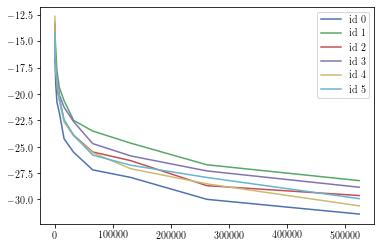

In [5]:
y = list(map(list, zip(*res_list_length)))

for i in range(6):
    plt.plot(x_length,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [6]:
res_list_sigs = []
x_sigs = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

for i in tqdm.tqdm(x_sigs):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=10.0,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=i,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=20)
    res_list_sigs.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       0
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [01:02<09:22, 62.54s/it]

---- Simulation stats ----
Err time:             -22.0348 dB
Err band:             -18.9393 dB
Err eigenval average: -21.8538 dB
Err eigenval hist:    -20.6418 dB
Err eigenval kde:     -21.2001 dB
Err eigenval mle:     -20.9825 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       0
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [01:58<08:04, 60.52s/it]

---- Simulation stats ----
Err time:             -22.1868 dB
Err band:             -19.7566 dB
Err eigenval average: -21.3160 dB
Err eigenval hist:    -20.0377 dB
Err eigenval kde:     -21.0453 dB
Err eigenval mle:     -21.6485 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [02:52<06:51, 58.73s/it]

---- Simulation stats ----
Err time:             -21.9980 dB
Err band:             -19.1089 dB
Err eigenval average: -20.0146 dB
Err eigenval hist:    -19.5202 dB
Err eigenval kde:     -20.1177 dB
Err eigenval mle:     -20.7254 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [03:43<05:38, 56.36s/it]

---- Simulation stats ----
Err time:             -22.7005 dB
Err band:             -19.0479 dB
Err eigenval average: -19.3499 dB
Err eigenval hist:    -19.3175 dB
Err eigenval kde:     -19.3292 dB
Err eigenval mle:     -19.7099 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [04:31<04:28, 53.68s/it]

---- Simulation stats ----
Err time:             -22.1070 dB
Err band:             -19.5971 dB
Err eigenval average: -19.5675 dB
Err eigenval hist:    -18.4592 dB
Err eigenval kde:     -19.0061 dB
Err eigenval mle:     -19.3532 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [05:15<03:23, 50.90s/it]

---- Simulation stats ----
Err time:             -22.1632 dB
Err band:             -7.8865 dB
Err eigenval average: -19.1117 dB
Err eigenval hist:    -17.3033 dB
Err eigenval kde:     -18.7130 dB
Err eigenval mle:     -18.8656 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       3
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [05:57<02:24, 48.23s/it]

---- Simulation stats ----
Err time:             -22.6061 dB
Err band:             -5.7143 dB
Err eigenval average: -17.4088 dB
Err eigenval hist:    -15.1437 dB
Err eigenval kde:     -16.8078 dB
Err eigenval mle:     -16.6405 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       3
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [06:38<01:31, 45.99s/it]

---- Simulation stats ----
Err time:             -22.2258 dB
Err band:             -4.2475 dB
Err eigenval average: -16.8994 dB
Err eigenval hist:    -15.0054 dB
Err eigenval kde:     -16.4893 dB
Err eigenval mle:     -16.0578 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [07:15<00:43, 43.36s/it]

---- Simulation stats ----
Err time:             -21.5511 dB
Err band:             -3.6547 dB
Err eigenval average: -12.9701 dB
Err eigenval hist:    -14.2445 dB
Err eigenval kde:     -11.6742 dB
Err eigenval mle:     -15.0622 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [08:01<00:00, 48.18s/it]

---- Simulation stats ----
Err time:             -21.9163 dB
Err band:             -3.0500 dB
Err eigenval average: -3.3440 dB
Err eigenval hist:    -3.2897 dB
Err eigenval kde:     -2.9903 dB
Err eigenval mle:     -4.4296 dB


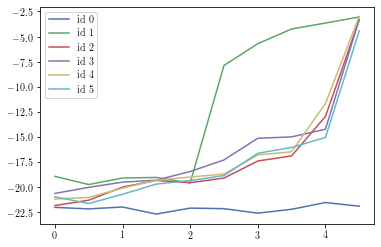

In [7]:
y = list(map(list, zip(*res_list_sigs)))

for i in range(6):
    plt.plot(x_sigs,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [17]:
res_list_snr = []
x_snr = range(-30, 20, 5)

for i in tqdm.tqdm(x_snr):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=i,  # in dB
        noise_power=0.0,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=1,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=20)
    res_list_snr.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   -30.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -30.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [01:03<09:29, 63.31s/it]

---- Simulation stats ----
Err time:             -22.0724 dB
Err band:             -19.0613 dB
Err eigenval average: -20.2260 dB
Err eigenval hist:    -19.7382 dB
Err eigenval kde:     -20.5765 dB
Err eigenval mle:     -20.9829 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   -25.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -25.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [02:02<08:16, 62.00s/it]

---- Simulation stats ----
Err time:             -22.6514 dB
Err band:             -19.4599 dB
Err eigenval average: -20.5927 dB
Err eigenval hist:    -20.0099 dB
Err eigenval kde:     -21.2229 dB
Err eigenval mle:     -20.8847 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   -20.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -20.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [03:00<07:06, 61.00s/it]

---- Simulation stats ----
Err time:             -22.3110 dB
Err band:             -19.1405 dB
Err eigenval average: -19.5337 dB
Err eigenval hist:    -19.5600 dB
Err eigenval kde:     -20.2792 dB
Err eigenval mle:     -20.6709 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   -15.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -15.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [03:55<05:55, 59.18s/it]

---- Simulation stats ----
Err time:             -22.6441 dB
Err band:             -19.6353 dB
Err eigenval average: -20.2294 dB
Err eigenval hist:    -20.3286 dB
Err eigenval kde:     -20.9061 dB
Err eigenval mle:     -21.3519 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   -10.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -10.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [04:49<04:48, 57.60s/it]

---- Simulation stats ----
Err time:             -22.3207 dB
Err band:             -19.3501 dB
Err eigenval average: -20.4022 dB
Err eigenval hist:    -19.8594 dB
Err eigenval kde:     -20.4773 dB
Err eigenval mle:     -20.4680 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   -5.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -5.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [05:41<03:43, 55.93s/it]

---- Simulation stats ----
Err time:             -21.9988 dB
Err band:             -19.3047 dB
Err eigenval average: -20.1270 dB
Err eigenval hist:    -19.8617 dB
Err eigenval kde:     -20.2247 dB
Err eigenval mle:     -20.7088 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   0.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            0.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [06:32<02:42, 54.28s/it]

---- Simulation stats ----
Err time:             -22.8925 dB
Err band:             -18.8713 dB
Err eigenval average: -21.0236 dB
Err eigenval hist:    -20.5881 dB
Err eigenval kde:     -21.2264 dB
Err eigenval mle:     -21.1956 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   5.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            5.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [07:21<01:45, 52.89s/it]

---- Simulation stats ----
Err time:             -22.5708 dB
Err band:             -18.1081 dB
Err eigenval average: -21.2951 dB
Err eigenval hist:    -19.8332 dB
Err eigenval kde:     -21.1245 dB
Err eigenval mle:     -21.0897 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   10.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            10.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [08:10<00:51, 51.58s/it]

---- Simulation stats ----
Err time:             -22.7308 dB
Err band:             -16.8342 dB
Err eigenval average: -21.4628 dB
Err eigenval hist:    -19.3991 dB
Err eigenval kde:     -20.8656 dB
Err eigenval mle:     -20.8166 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   15.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            15.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [08:58<00:00, 53.83s/it]

---- Simulation stats ----
Err time:             -22.3176 dB
Err band:             -15.7403 dB
Err eigenval average: -21.7874 dB
Err eigenval hist:    -19.9545 dB
Err eigenval kde:     -20.7425 dB
Err eigenval mle:     -20.9079 dB


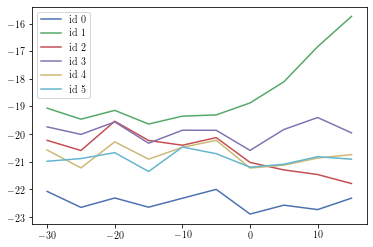

In [18]:
y = list(map(list, zip(*res_list_snr)))

for i in range(6):
    plt.plot(x_snr,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [19]:
res_list_cov1 = []
x_cov1 = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for i in tqdm.tqdm(x_cov1):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=10.0,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=1,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=i)
    res_list_cov1.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [00:31<04:42, 31.35s/it]

---- Simulation stats ----
Err time:             -22.1714 dB
Err band:             -19.2919 dB
Err eigenval average: -19.5902 dB
Err eigenval hist:    -19.5756 dB
Err eigenval kde:     -19.3970 dB
Err eigenval mle:     -20.7982 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [01:09<04:26, 33.35s/it]

---- Simulation stats ----
Err time:             -22.0276 dB
Err band:             -19.3882 dB
Err eigenval average: -20.3485 dB
Err eigenval hist:    -19.6668 dB
Err eigenval kde:     -20.3901 dB
Err eigenval mle:     -20.4497 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [01:59<04:28, 38.35s/it]

---- Simulation stats ----
Err time:             -22.7193 dB
Err band:             -19.1374 dB
Err eigenval average: -20.4896 dB
Err eigenval hist:    -19.4979 dB
Err eigenval kde:     -20.8657 dB
Err eigenval mle:     -20.6634 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [02:54<04:20, 43.43s/it]

---- Simulation stats ----
Err time:             -22.1142 dB
Err band:             -19.1812 dB
Err eigenval average: -20.2821 dB
Err eigenval hist:    -19.7478 dB
Err eigenval kde:     -20.5940 dB
Err eigenval mle:     -20.1996 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [03:56<04:05, 49.10s/it]

---- Simulation stats ----
Err time:             -22.3296 dB
Err band:             -19.0134 dB
Err eigenval average: -20.7583 dB
Err eigenval hist:    -19.5762 dB
Err eigenval kde:     -20.7328 dB
Err eigenval mle:     -20.4715 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [05:07<03:42, 55.63s/it]

---- Simulation stats ----
Err time:             -22.2128 dB
Err band:             -19.5092 dB
Err eigenval average: -20.0715 dB
Err eigenval hist:    -20.2070 dB
Err eigenval kde:     -20.7108 dB
Err eigenval mle:     -20.4740 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [06:27<03:08, 62.84s/it]

---- Simulation stats ----
Err time:             -22.2304 dB
Err band:             -18.7836 dB
Err eigenval average: -19.9336 dB
Err eigenval hist:    -20.0338 dB
Err eigenval kde:     -20.1914 dB
Err eigenval mle:     -20.3091 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [07:53<02:19, 69.63s/it]

---- Simulation stats ----
Err time:             -22.0945 dB
Err band:             -19.4786 dB
Err eigenval average: -20.4875 dB
Err eigenval hist:    -19.7390 dB
Err eigenval kde:     -20.4536 dB
Err eigenval mle:     -20.4377 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [09:27<01:17, 77.06s/it]

---- Simulation stats ----
Err time:             -22.8328 dB
Err band:             -19.6026 dB
Err eigenval average: -19.6944 dB
Err eigenval hist:    -19.9080 dB
Err eigenval kde:     -20.2514 dB
Err eigenval mle:     -20.9044 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [11:14<00:00, 67.50s/it]

---- Simulation stats ----
Err time:             -22.3192 dB
Err band:             -19.0345 dB
Err eigenval average: -20.6784 dB
Err eigenval hist:    -19.9082 dB
Err eigenval kde:     -20.1405 dB
Err eigenval mle:     -20.1695 dB


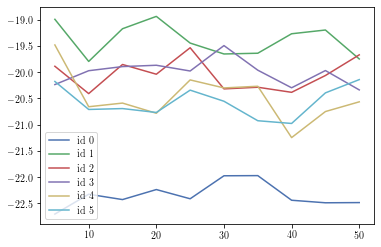

In [11]:
y = list(map(list, zip(*res_list_cov1)))

for i in range(6):
    plt.plot(x_cov1,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [12]:
res_list_cov2 = []
x_cov2 = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for i in tqdm.tqdm(x_cov2):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=10.0,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=2.5,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=i)
    res_list_cov2.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [00:29<04:21, 29.08s/it]

---- Simulation stats ----
Err time:             -21.9859 dB
Err band:             -7.1813 dB
Err eigenval average: -8.1447 dB
Err eigenval hist:    -10.0522 dB
Err eigenval kde:     -6.5367 dB
Err eigenval mle:     -14.3050 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [01:00<03:57, 29.75s/it]

---- Simulation stats ----
Err time:             -22.1536 dB
Err band:             -6.5078 dB
Err eigenval average: -18.9250 dB
Err eigenval hist:    -17.3789 dB
Err eigenval kde:     -18.0754 dB
Err eigenval mle:     -18.3852 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [01:38<03:46, 32.41s/it]

---- Simulation stats ----
Err time:             -22.2272 dB
Err band:             -7.6587 dB
Err eigenval average: -18.7438 dB
Err eigenval hist:    -16.6203 dB
Err eigenval kde:     -17.9826 dB
Err eigenval mle:     -18.5027 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [02:21<03:32, 35.44s/it]

---- Simulation stats ----
Err time:             -22.1616 dB
Err band:             -6.3750 dB
Err eigenval average: -19.1862 dB
Err eigenval hist:    -17.0627 dB
Err eigenval kde:     -18.2714 dB
Err eigenval mle:     -18.6317 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [03:39<04:00, 48.16s/it]

---- Simulation stats ----
Err time:             -22.1712 dB
Err band:             -8.0011 dB
Err eigenval average: -18.6560 dB
Err eigenval hist:    -17.0944 dB
Err eigenval kde:     -18.3983 dB
Err eigenval mle:     -18.3166 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [04:32<03:18, 49.59s/it]

---- Simulation stats ----
Err time:             -21.9999 dB
Err band:             -7.2080 dB
Err eigenval average: -19.1369 dB
Err eigenval hist:    -17.6551 dB
Err eigenval kde:     -18.5603 dB
Err eigenval mle:     -18.6787 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [05:33<02:38, 52.94s/it]

---- Simulation stats ----
Err time:             -22.4918 dB
Err band:             -7.4320 dB
Err eigenval average: -18.7170 dB
Err eigenval hist:    -18.1414 dB
Err eigenval kde:     -18.3718 dB
Err eigenval mle:     -18.7985 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [06:39<01:54, 57.14s/it]

---- Simulation stats ----
Err time:             -21.9571 dB
Err band:             -8.2661 dB
Err eigenval average: -18.4869 dB
Err eigenval hist:    -17.7733 dB
Err eigenval kde:     -17.5832 dB
Err eigenval mle:     -19.0081 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [07:57<01:03, 63.18s/it]

---- Simulation stats ----
Err time:             -22.3565 dB
Err band:             -8.6923 dB
Err eigenval average: -17.2161 dB
Err eigenval hist:    -17.2726 dB
Err eigenval kde:     -16.9331 dB
Err eigenval mle:     -18.6501 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [09:16<00:00, 55.61s/it]

---- Simulation stats ----
Err time:             -21.7614 dB
Err band:             -7.2132 dB
Err eigenval average: -17.2341 dB
Err eigenval hist:    -17.5382 dB
Err eigenval kde:     -16.6462 dB
Err eigenval mle:     -17.9993 dB


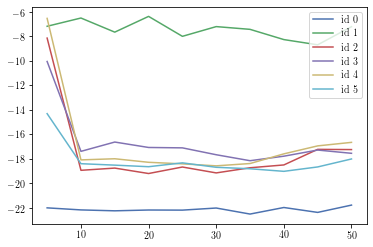

In [13]:
y = list(map(list, zip(*res_list_cov2)))

for i in range(6):
    plt.plot(x_cov2,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [14]:
res_list_cov3 = []
x_cov3 = [20, 40, 60, 80, 100]

for i in tqdm.tqdm(x_cov3):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=10.0,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=4,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=i)
    res_list_cov3.append(res)

  0%|          | 0/5 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 1/5 [00:37<02:28, 37.01s/it]

---- Simulation stats ----
Err time:             -21.9820 dB
Err band:             -3.6962 dB
Err eigenval average: -12.4669 dB
Err eigenval hist:    -14.0213 dB
Err eigenval kde:     -11.0558 dB
Err eigenval mle:     -14.7366 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 2/5 [01:36<02:11, 43.68s/it]

---- Simulation stats ----
Err time:             -22.3760 dB
Err band:             -4.6013 dB
Err eigenval average: -14.4577 dB
Err eigenval hist:    -13.8715 dB
Err eigenval kde:     -13.8558 dB
Err eigenval mle:     -13.9626 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 3/5 [02:49<01:44, 52.45s/it]

---- Simulation stats ----
Err time:             -22.5407 dB
Err band:             -3.3125 dB
Err eigenval average: -14.2670 dB
Err eigenval hist:    -13.7011 dB
Err eigenval kde:     -13.7078 dB
Err eigenval mle:     -14.0995 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 4/5 [04:28<01:06, 66.58s/it]

---- Simulation stats ----
Err time:             -22.5973 dB
Err band:             -3.1534 dB
Err eigenval average: -15.4425 dB
Err eigenval hist:    -14.9591 dB
Err eigenval kde:     -14.7750 dB
Err eigenval mle:     -15.5242 dB
---- Simulation parameters ----
Generations:    50
Iterations:     5
Total iters:    250
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 5/5 [08:53<00:00, 106.66s/it]

---- Simulation stats ----
Err time:             -22.3878 dB
Err band:             -3.3263 dB
Err eigenval average: -12.9564 dB
Err eigenval hist:    -13.1027 dB
Err eigenval kde:     -11.9486 dB
Err eigenval mle:     -13.9863 dB


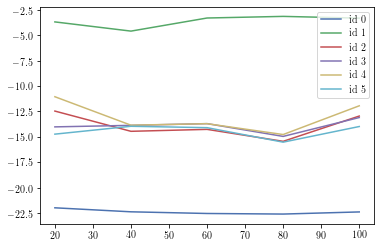

In [15]:
y = list(map(list, zip(*res_list_cov3)))

for i in range(6):
    plt.plot(x_cov3,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

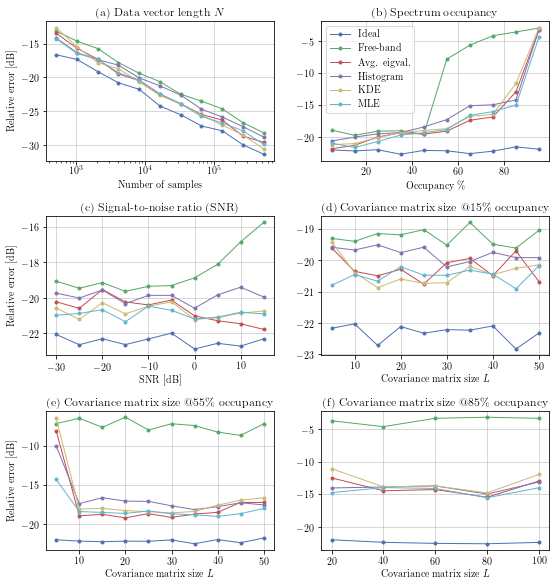

In [20]:
types = [r'Ideal', r'Free-band', r'Avg. eigval.', r'Histogram', r'KDE', r'MLE']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 8.25))

y = list(map(list, zip(*res_list_length)))
for i in range(6):
    axs[0, 0].plot(x_length, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[0, 0].set_xlabel(r'Number of samples')
axs[0, 0].set_ylabel(r'Relative error [dB]')
axs[0, 0].set_title(r'(a) Data vector length $N$')
axs[0, 0].set_xscale('log')
axs[0, 0].grid(linewidth=0.5)

x_special = list(map(lambda x: round((x/5+0.05)*100, 2), x_sigs))
y = list(map(list, zip(*res_list_sigs)))
for i in range(6):
    axs[0, 1].plot(x_special, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[0, 1].set_xlabel(r'Occupancy \%')
# axs[0, 1].set_ylabel(r'Relative error [dB]')
axs[0, 1].set_title(r'(b) Spectrum occupancy')
axs[0, 1].legend(loc=0)
axs[0, 1].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_snr)))
for i in range(6):
    axs[1, 0].plot(x_snr, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[1, 0].set_xlabel(r'SNR [dB]')
axs[1, 0].set_ylabel(r'Relative error [dB]')
axs[1, 0].set_title(r'(c) Signal-to-noise ratio (SNR)')
axs[1, 0].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_cov1)))
for i in range(6):
    axs[1, 1].plot(x_cov1, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[1, 1].set_xlabel(r'Covariance matrix size $L$')
# axs[1, 1].set_ylabel(r'Relative error [dB]')
axs[1, 1].set_title(r'(d) Covariance matrix size $@15\%$ occupancy')
axs[1, 1].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_cov2)))
for i in range(6):
    axs[2, 0].plot(x_cov2, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[2, 0].set_xlabel(r'Covariance matrix size $L$')
axs[2, 0].set_ylabel(r'Relative error [dB]')
axs[2, 0].set_title(r'(e) Covariance matrix size $@55\%$ occupancy')
axs[2, 0].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_cov3)))
for i in range(6):
    axs[2, 1].plot(x_cov3, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[2, 1].set_xlabel(r'Covariance matrix size $L$')
# axs[2, 1].set_ylabel(r'Relative error [dB]')
axs[2, 1].set_title(r'(f) Covariance matrix size $@85\%$ occupancy')
axs[2, 1].grid(linewidth=0.5)

plt.tight_layout()
plt.savefig('out/chap5/noise_estimation_comparison.pdf')